In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

### Objetivos:

1. Descrever a série temporal de acordo com as suas propriedades e componentes. Isto inclui a tendência,sazonalidade, estacionariedade, entre outros.
2. Descrever a estrutura do modelo ARIMA que melhor se ajusta aos dados.
3. Avaliar o desempenho de um modelo de regressão com validação cruzada
4. Seguindo o ponto 3.: Descrever o impacto dos seguintes aspectos no desempenho:
    1. Diferentes horizontes temporais;
    2. Desempenho nos valores extremos da série;
    3. Comparação de diferentes algoritmos de regressão.

In [2]:
url = 'https://raw.githubusercontent.com/vcerqueira/energy_load_data/main/energy_load_pt.csv'

In [3]:
df = pd.read_csv(url, parse_dates=['datetime'])# index_col='datetime')
print(df['load'].describe())

count    13102.000000
mean      5651.250725
std       1140.477714
min       3171.000000
25%       4646.250000
50%       5582.500000
75%       6542.750000
max       8857.000000
Name: load, dtype: float64


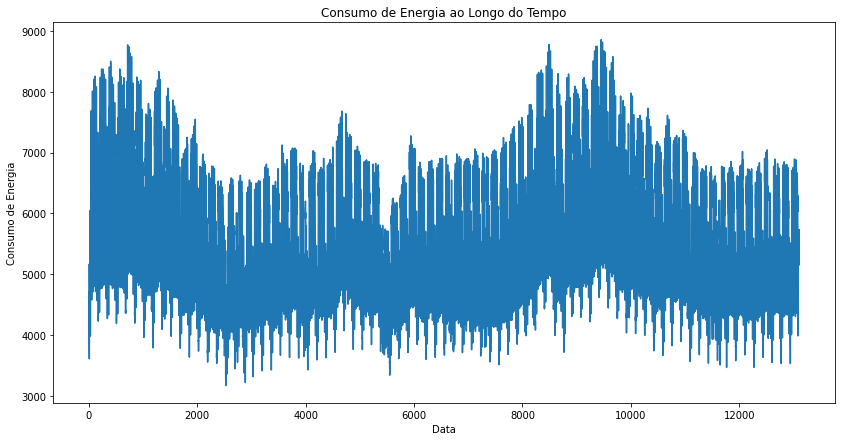

In [4]:
# Visualizando os dados
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['load'])
plt.title('Consumo de Energia ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Consumo de Energia')
plt.show()

In [5]:
missing_rows = df[df.isnull().any(axis=1)]
missing_rows

,datetime,load
2018,2021-02-09 10:00:00,NaN
10754,2022-02-08 10:00:00,NaN


In [6]:
df['load'] = df['load'].interpolate(method='linear')

In [7]:
series = pd.Series(df['load'])

In [8]:
series.index = pd.to_datetime(df['datetime'])

In [9]:
series.head()

datetime
2020-11-17 08:00:00    5159.0
2020-11-17 09:00:00    4985.0
2020-11-17 10:00:00    4717.0
2020-11-17 11:00:00    4356.0
2020-11-17 12:00:00    4086.0
Name: load, dtype: float64

In [10]:
# transformando a série para diária
d_series = series.resample('D').sum()
d_series

datetime
2020-11-17     68715.0
2020-11-18    128955.0
2020-11-19    151896.0
2020-11-20    156929.0
2020-11-21    159989.0
                ...   
2022-05-13    138330.0
2022-05-14    138984.0
2022-05-15    138011.0
2022-05-16    128779.0
2022-05-17     47908.0
Freq: D, Name: load, Length: 547, dtype: float64

In [11]:
series.tail()

datetime
2022-05-17 04:00:00    5190.0
2022-05-17 05:00:00    5297.0
2022-05-17 06:00:00    5441.0
2022-05-17 07:00:00    5735.0
2022-05-17 08:00:00    5418.0
Name: load, dtype: float64

<AxesSubplot:>

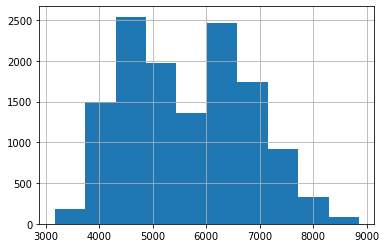

In [12]:
series.hist()

<AxesSubplot:>

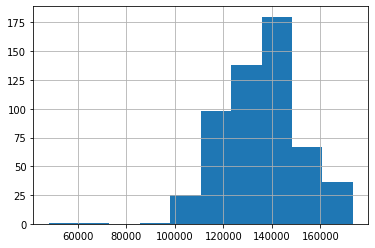

In [13]:
d_series.hist()

In [14]:
from pmdarima.arima import ndiffs, nsdiffs

c:\Users\Andre\anaconda3\lib\site-packages\pmdarima\__init__.py:108: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  "pmdarima support for 32-bit systems is ending with Python 3.10."


In [15]:
# kpss test
ndiffs(series, test='kpss')

1

In [16]:
ndiffs(d_series, test='kpss')

1

In [17]:
ndiffs(series, test='adf')

0

In [18]:
ndiffs(d_series, test='adf')

1

In [19]:
ndiffs(series, test='pp')

0

In [20]:
ndiffs(d_series, test='pp')

0

In [21]:
# Os testes foram contraditórios quanto a existir uma tendencia tanto para a série horária quanto para diária

In [22]:
# vamos utilizar a Transformada de Fourier (FFT) para encontrar um periodo dominante
fft_values = np.fft.fft(series)
fft_frequencies = np.fft.fftfreq(len(fft_values))
fft_values_abs = np.abs(fft_values)
dominant_frequency = np.abs(fft_frequencies[np.argmax(fft_values_abs[1:])])
period = 1 / dominant_frequency

print(f'O período dominante é: {period}')

O período dominante é: 23.956124314442416


In [23]:
fft_values = np.fft.fft(d_series)
fft_frequencies = np.fft.fftfreq(len(fft_values))
fft_values_abs = np.abs(fft_values)
dominant_frequency = np.abs(fft_frequencies[np.argmax(fft_values_abs[1:])])
period = 1 / dominant_frequency

print(f'O período dominante é: {period}')

O período dominante é: 7.103896103896104


In [24]:
# o periodo dominante é 24 horas para horária e 7 para diária
# Encontrando sazonalidade

nsdiffs(series, test='ocsb', m=24)

0

In [25]:
nsdiffs(d_series, test='ocsb', m=7)

0

In [26]:
nsdiffs(series, test='ch', m=24)

1

In [27]:
nsdiffs(d_series, test='ch', m=7)

0

In [28]:
# aqui os testes também foram contraditórios para série horária mas não para diária

<AxesSubplot:xlabel='datetime'>

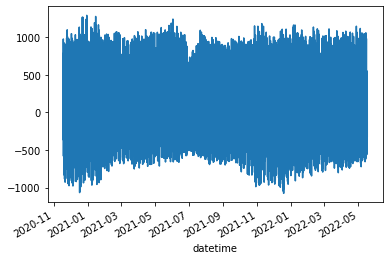

In [29]:
# vamos remover a tendência
series.diff(periods=1).plot()

<AxesSubplot:xlabel='datetime'>

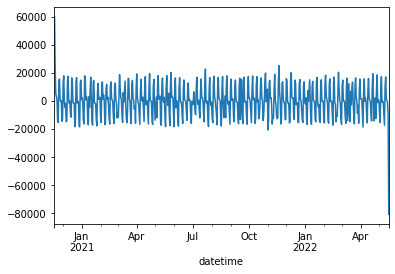

In [30]:
d_series.diff(periods=1).plot()

<AxesSubplot:xlabel='datetime'>

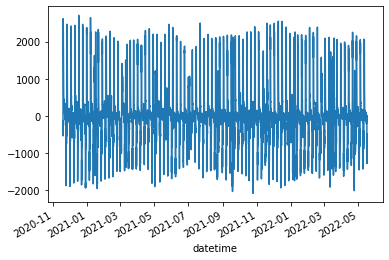

In [31]:
# vamos remover a sazonalidade
series.diff(periods=24).plot()

<AxesSubplot:xlabel='datetime'>

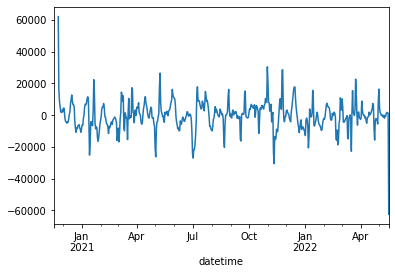

In [32]:
d_series.diff(periods=7).plot()

<AxesSubplot:xlabel='datetime'>

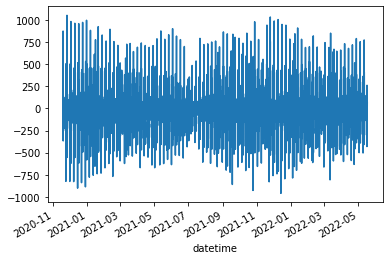

In [33]:
# residuos
series.diff(periods=1).diff(periods=24).plot()

<AxesSubplot:xlabel='datetime'>

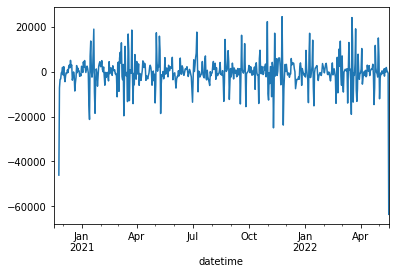

In [34]:
d_series.diff(periods=1).diff(periods=7).plot()

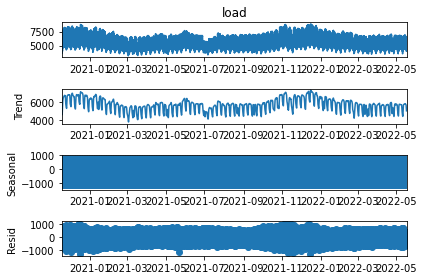

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series, model='additive', period=24)
result.plot()
plt.show()

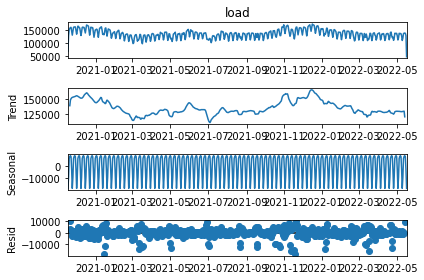

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(d_series, model='additive', period=7)
result.plot()
plt.show()

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

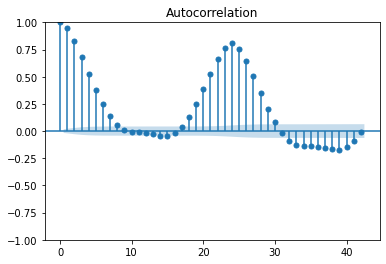

In [38]:
plt = plot_acf(series)

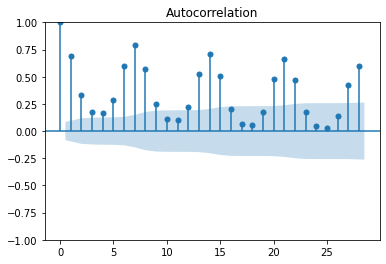

In [39]:
plt = plot_acf(d_series)

c:\Users\Andre\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


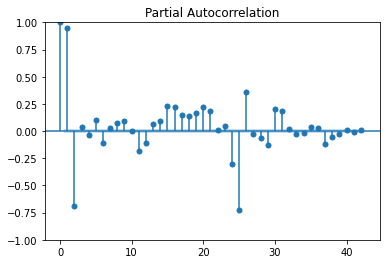

In [40]:
plt = plot_pacf(series)

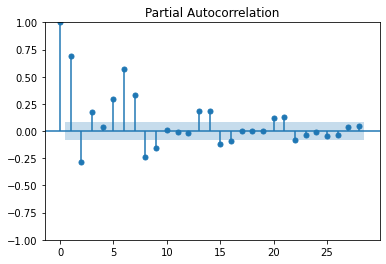

In [41]:
plt = plot_pacf(d_series)

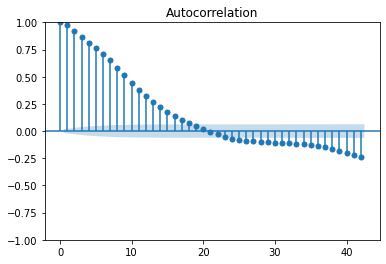

In [42]:
plt = plot_acf(series.diff(periods=24)[24:])

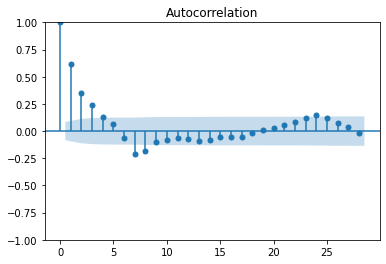

In [43]:
plt = plot_acf(d_series.diff(periods=7)[7:])

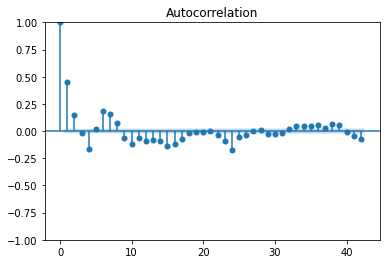

In [44]:
plt = plot_acf(series.diff().diff(periods=24)[25:])

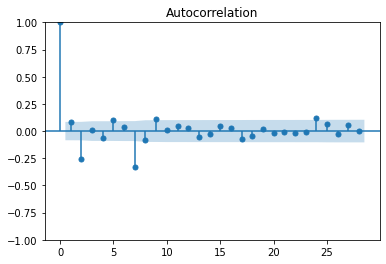

In [45]:
plt = plot_acf(d_series.diff().diff(periods=7)[8:])

In [46]:
# Verificar estacionariedade

from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -12.438601254810203
p-value: 3.7976646281150854e-23


In [47]:
result_1 = adfuller(d_series)
print('ADF Statistic:', result_1[0])
print('p-value:', result_1[1])

ADF Statistic: -1.389597840403159
p-value: 0.5872527599477121


os valores ADF Statistic: -12.435861954778304 e p-value: 3.8485901958947783e-23 indicam a estacionariedade da série horária. Mas o p-value é bem maior que 0,05 da série diária, não indicando estacionariedade.

In [48]:
#heterocedastidade
from src.heteroskedasticity import Heteroskedasticity
test_results = Heteroskedasticity.run_all_tests(series)
test_results

{'White': 2.946923414538571e-17,
 'Breusch-Pagan': 1.4939312394194214e-15,
 'Goldfeld-Quandt': 0.0011005528784623897}

In [49]:
test_results = Heteroskedasticity.run_all_tests(d_series)
test_results

{'White': 0.032102870961068425,
 'Breusch-Pagan': 0.3781589871956538,
 'Goldfeld-Quandt': 0.23588450918675}

 'White': 2.946923414538571e-17,
 'Breusch-Pagan': 1.4939312394194214e-15,
 'Goldfeld-Quandt': 0.0011005528784623897
O valor dos testes 'White' e 'Breusch-Pagan' são extremamente pequenos e o Goldfeld-Quandt é muito menor que 0,05 indicando que temos heterocedasticidade nos dados para série horária.
Já para série diária, somente o teste 'White' menor que 0,05 indica heterocedasticidade.

In [50]:
# boxcox se for confirmada a heterocedastidade

In [51]:
np.log(series)

datetime
2020-11-17 08:00:00    8.548498
2020-11-17 09:00:00    8.514189
2020-11-17 10:00:00    8.458928
2020-11-17 11:00:00    8.379309
2020-11-17 12:00:00    8.315322
                         ...   
2022-05-17 04:00:00    8.554489
2022-05-17 05:00:00    8.574896
2022-05-17 06:00:00    8.601718
2022-05-17 07:00:00    8.654343
2022-05-17 08:00:00    8.597482
Name: load, Length: 13104, dtype: float64

In [52]:
np.log(d_series)

datetime
2020-11-17    11.137723
2020-11-18    11.767219
2020-11-19    11.930951
2020-11-20    11.963549
2020-11-21    11.982860
                ...    
2022-05-13    11.837397
2022-05-14    11.842114
2022-05-15    11.835089
2022-05-16    11.765853
2022-05-17    10.777038
Freq: D, Name: load, Length: 547, dtype: float64

In [53]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [54]:
transformed_data, best_lambda = boxcox(series)

print(transformed_data[:5])
print(series.values[:5])
print(best_lambda)

[30.70977979 30.40844496 29.92860173 29.24901408 28.71274623]
[5159. 4985. 4717. 4356. 4086.]
0.2546844721371134


In [55]:
transformed_data_1, best_lambda_1 = boxcox(d_series)

print(transformed_data_1[:5])
print(d_series.values[:5])
print(best_lambda_1)

[2.97688287e+07 8.08170144e+07 1.04789871e+08 1.10351912e+08
 1.13785287e+08]
[ 68715. 128955. 151896. 156929. 159989.]
1.5865481114300348


<AxesSubplot:>

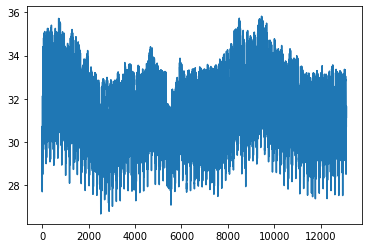

In [56]:
pd.Series(transformed_data).plot()

<AxesSubplot:>

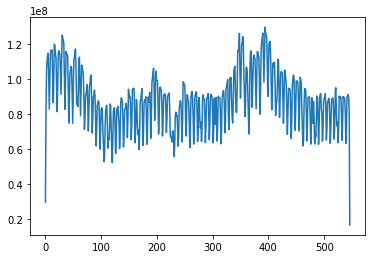

In [57]:
pd.Series(transformed_data_1).plot()

<AxesSubplot:>

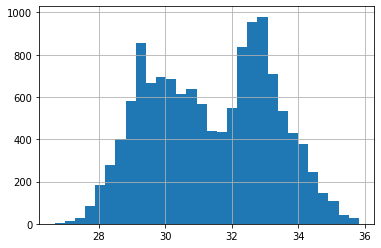

In [58]:
pd.Series(transformed_data).hist(bins=30)

<AxesSubplot:>

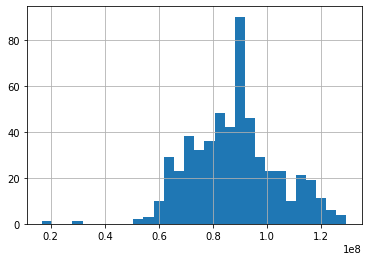

In [59]:
pd.Series(transformed_data_1).hist(bins=30)

2- Descrever a estrutura do modelo ARIMA que melhor se ajusta aos dados.

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
serie_t = pd.Series(transformed_data_1)

In [62]:
serie_t = serie_t.astype(np.float32)

In [63]:
#Encontrando a estrutura do modelo ARIMA que melhor se ajusta aos dados.

train, test = train_test_split(serie_t, shuffle=False, test_size=30)

len(test)

30

In [64]:
import pmdarima as pm

model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True)

#model = pm.auto_arima(train, m=7 , trace=True, suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=17527.837, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=18210.409, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17826.105, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17875.767, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=18208.464, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=17689.967, Time=0.28 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=17588.317, Time=0.27 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=17528.846, Time=1.37 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=17528.999, Time=1.44 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=17819.440, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=17645.921, Time=0.59 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=17555.873, Time=0.74 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=17559.255, Time=0.33 sec
 ARIMA(2,1,1)(1,0,1)[7] i

In [65]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)

In [66]:
from src.error import MASE

In [67]:
MASE(train, test, forecast)

0.5013118875493517

<AxesSubplot:title={'center':'forecast_arima'}>

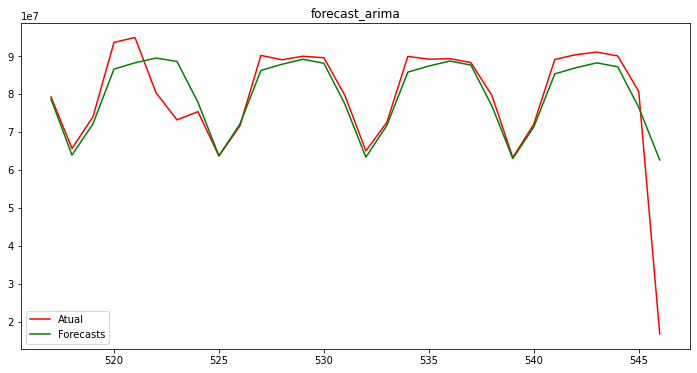

In [68]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (12,6))
forecasts.plot(legend=True, color = 'green')

In [69]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  517
Model:             SARIMAX(5, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -8687.769
Date:                           Mon, 05 Aug 2024   AIC                          17395.537
Time:                                   21:56:14   BIC                          17437.998
Sample:                                        0   HQIC                         17412.176
                                           - 517                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3120      0.291     -1.074      0.283      -0.882       0.258
ar.L2         -0.2491      0.114     -2.189

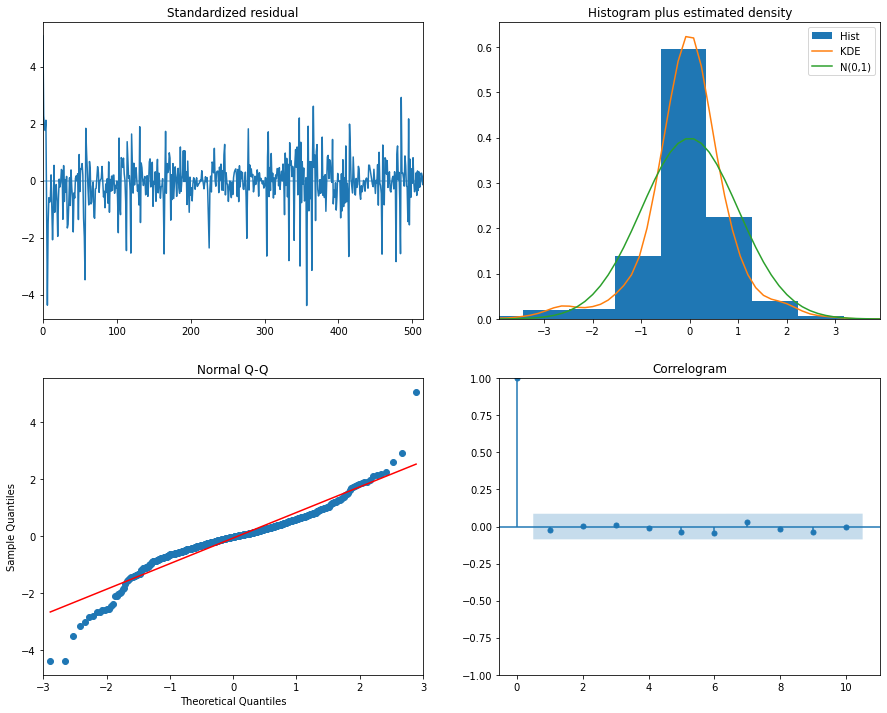

In [70]:
plot = model.plot_diagnostics(figsize = (15,12))


3-Avaliar o desempenho de um modelo de regressão com validação cruzada

In [71]:
from src.tde import UnivariateTDE

df_tde = UnivariateTDE (data=serie_t, k = 7, horizon= 1)
df_tde

,t-6,t-5,t-4,t-3,t-2,t-1,t-0,t+1
0,29768828.0,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0
1,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0
2,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0
3,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0
4,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0
...,...,...,...,...,...,...,...,...
535,89156080.0,89273648.0,88264832.0,79626128.0,63253368.0,72037072.0,89081856.0,90335392.0
536,89273648.0,88264832.0,79626128.0,63253368.0,72037072.0,89081856.0,90335392.0,91013928.0
537,88264832.0,79626128.0,63253368.0,72037072.0,89081856.0,90335392.0,91013928.0,90005104.0
538,79626128.0,63253368.0,72037072.0,89081856.0,90335392.0,91013928.0,90005104.0,80642088.0


In [72]:
X = df_tde.drop('t+1', axis = 1)
y = df_tde['t+1']

In [73]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, shuffle=False)

In [74]:
#RandomForestRegressor

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
model_RF = RandomForestRegressor(n_estimators=100, max_depth=100)
model_RF.fit(X_train, y_train)


RandomForestRegressor(max_depth=100)

In [77]:
forecasts_RF = model_RF.predict(X_test)
forecasts_RF[:10]

array([8.17856015e+07, 9.51850005e+07, 1.12751288e+08, 1.15611219e+08,
       1.19767077e+08, 1.19860368e+08, 1.04032027e+08, 9.51896444e+07,
       9.18531630e+07, 1.17801637e+08])

In [78]:
MASE(y_train, y_test, forecasts_RF)

0.45787123194824453

<AxesSubplot:title={'center':'forecasts_RF'}>

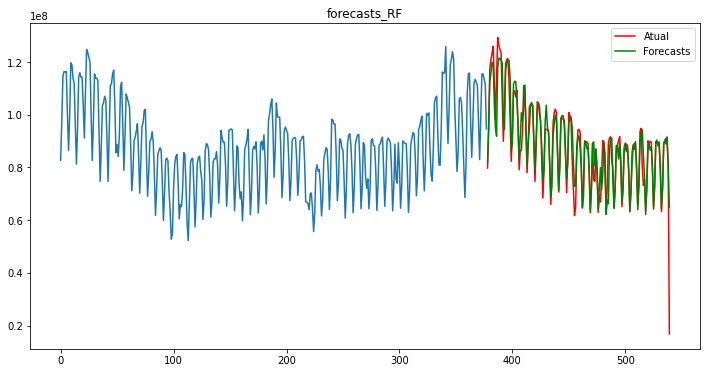

In [79]:
y_test = y_test.rename('Atual')
forecasts = pd.Series(forecasts_RF, index = y_test.index).rename('Forecasts')
ax = y_train.plot()
ax = y_test.plot(legend = True, color='red', title = 'forecasts_RF',figsize = (12,6))
forecasts.plot(legend=True, color = 'green')

In [80]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

In [81]:
ridge = Ridge()
lasso = Lasso()
linear_reg = LinearRegression()
rf = RandomForestRegressor()
tree = DecisionTreeRegressor()
lgbm = LGBMRegressor()

In [82]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
linear_reg.fit(X_train, y_train)
tree.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 378, number of used features: 7
[LightGBM] [Info] Start training from score 87515469.682540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.359e+15, tolerance: 9.221e+12
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


LGBMRegressor()

In [83]:
models = [ridge,lasso,linear_reg,tree,lgbm,model_RF]
colors = ['black','yellow','blue', 'green', 'purple','orange']
forecasts1 = []
for j,m in enumerate(models):
    print (j)
    pred = m.predict(X_test)
    pred = pd.Series(pred, index=y_test.index).rename(f'Forecast {j}')
    forecasts1.append(pred)

0
1
2
3
4
5


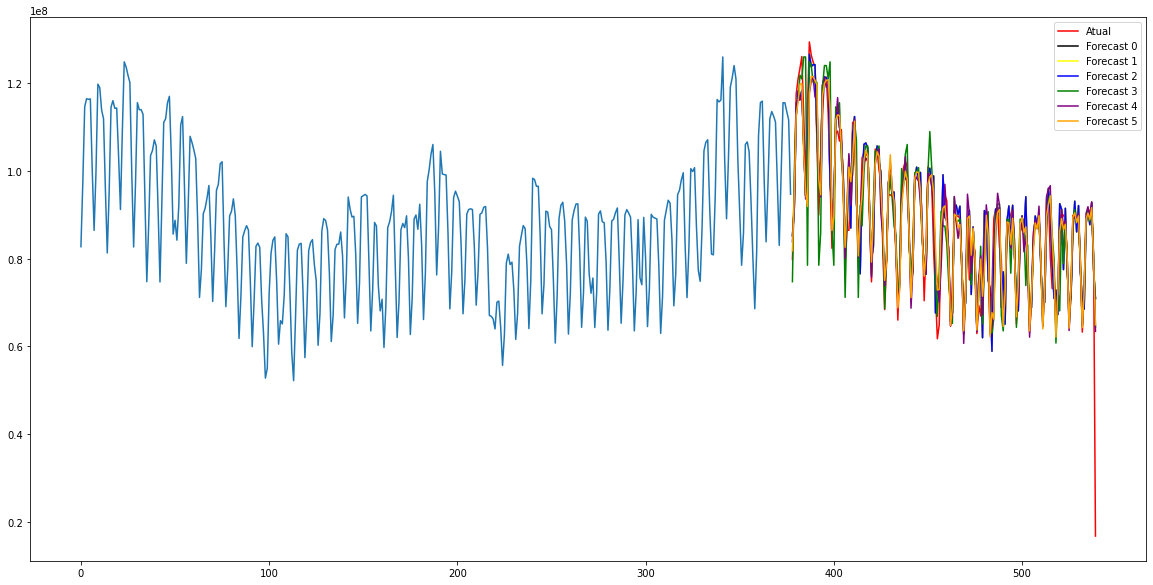

In [84]:
ax = y_train.plot()
ax = y_test.plot(legend = True, color ='red', figsize=(20,10))
for j, pred in enumerate(forecasts1):
    pred.plot(legend = True, color = colors[j])

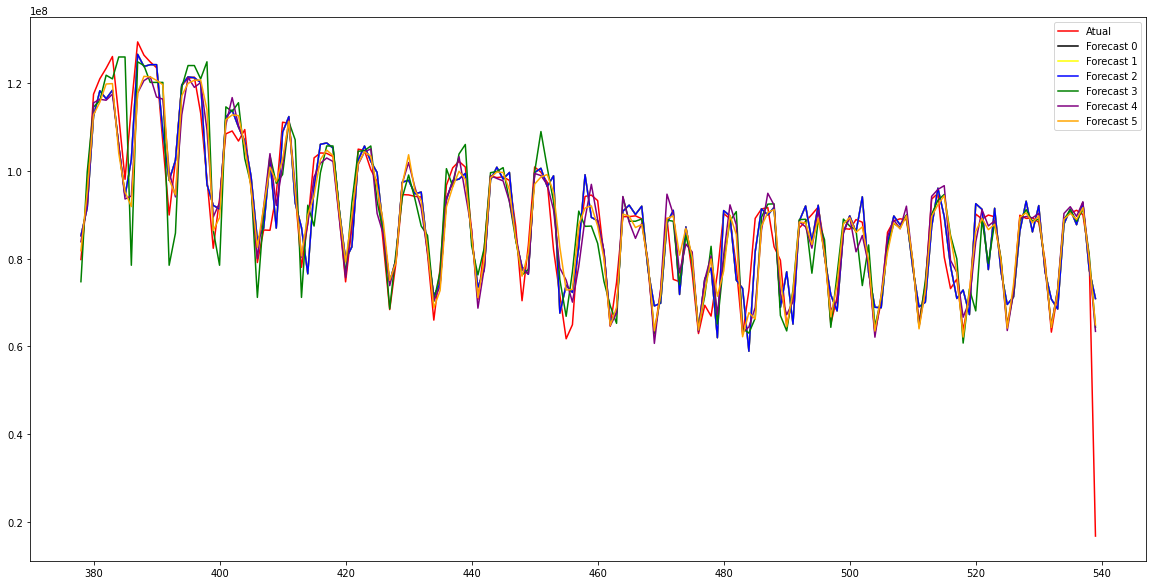

In [85]:
ax = y_test.plot(legend = True, color ='red', figsize=(20,10))
for j, pred in enumerate(forecasts1):
    pred.plot(legend = True, color = colors[j])

In [86]:
for pred in forecasts1:
    print(MASE(y_train,y_test,pred))

0.5092034810706748
0.5092035394617057
0.5092035394617057
0.6251609742877683
0.4894899085120851
0.45787123194824453


Entre os modelos o RandomForest teve o melhor MASE, mas vamos fazer a Estimação de Desempenho

In [87]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

cv = TimeSeriesSplit(n_splits=5)

cv_err = []
for tr_idx, ts_idx in cv.split(X_train, y_train):
    print('Training indices:')
    print(tr_idx[-5:])
    X_tr = X_train.values[tr_idx]
    y_tr = y_train.values[tr_idx]

    X_vl = X_train.values[ts_idx]
    y_vl = y_train.values[ts_idx]

    print('Training the model')
    model = Ridge()

    model.fit(X_tr, y_tr)
    print('Making predictions')
    pred = model.predict(X_vl)

    print('Computing error')
    err = mean_absolute_error(y_vl, pred)
    cv_err.append(err)

    
print(cv_err)

Training indices:
[58 59 60 61 62]
Training the model
Making predictions
Computing error
Training indices:
[121 122 123 124 125]
Training the model
Making predictions
Computing error
Training indices:
[184 185 186 187 188]
Training the model
Making predictions
Computing error
Training indices:
[247 248 249 250 251]
Training the model
Making predictions
Computing error
Training indices:
[310 311 312 313 314]
Training the model
Making predictions
Computing error
[5784812.5, 3790748.0, 3684099.8, 3491271.5, 5277423.5]


In [88]:
# erro estimado em validação cruzada

print(f'Average error is: {np.mean(cv_err)}')

Average error is: 4405671.0


In [89]:
# erro que obtemos no teste
model = Ridge()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 4360289.0


In [90]:
model_list = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'LGBMRegressor' : LGBMRegressor(),
    'LinearRegression' : LinearRegression()

}

from sklearn.model_selection import cross_val_score

In [91]:
err_by_method = {}
for method in model_list:
    print(f'Running model: {method}')
    cv_error = cross_val_score(model_list[method],
                               X_train,
                               y_train,
                               cv=cv,
                               scoring='neg_mean_absolute_error')

    err_by_method[method] = -np.mean(cv_error)

Running model: Ridge
Running model: Lasso
Running model: RandomForestRegressor
Running model: DecisionTreeRegressor
Running model: KNeighborsRegressor
Running model: LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 7
[LightGBM] [Info] Start training from score 103189934.349206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.699e+14, tolerance: 1.075e+12
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e+15, tolerance: 3.936e+12
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\Andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<AxesSubplot:>

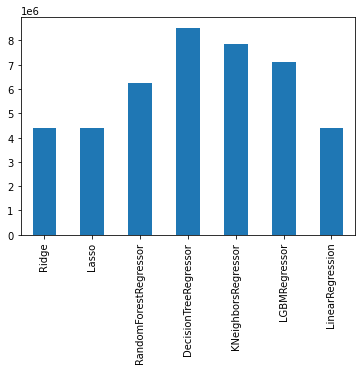

In [92]:
pd.Series(err_by_method).plot.bar()

In [93]:
from pprint import pprint
pprint(err_by_method)

{'DecisionTreeRegressor': 8529986.031746032,
 'KNeighborsRegressor': 7846595.45,
 'LGBMRegressor': 7125164.565674421,
 'Lasso': 4405673.9,
 'LinearRegression': 4405675.4,
 'RandomForestRegressor': 6227460.0355555555,
 'Ridge': 4405674.1}


In [94]:
#selecionando os parâmetros 

In [95]:
from sklearn.model_selection import GridSearchCV


parameters = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 5, 10]}

In [96]:
model = KNeighborsRegressor()
cv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           cv=cv, 
                           refit=True)


In [97]:
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 5, 10],
                         'weights': ['uniform', 'distance']})

In [98]:
grid_search.best_estimator_

KNeighborsRegressor(weights='distance')

In [99]:
pred_test_best = grid_search.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test_best)
print(f'Test error is: {err_test}')

Test error is: 3964582.129978706


In [100]:
#horizonte temporal 1 semana

In [101]:
serie_t_tde = UnivariateTDE(serie_t,k=7, horizon=7)
serie_t_tde.head()

,t-6,t-5,t-4,t-3,t-2,t-1,t-0,t+1,t+2,t+3,t+4,t+5,t+6,t+7
0,29768828.0,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0
1,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0
2,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0,99713976.0
3,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0,99713976.0,119739504.0
4,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0,99713976.0,119739504.0,118948232.0


In [102]:
is_future = serie_t_tde.columns.str.contains('\+')
X = serie_t_tde.iloc[:,~is_future]
Y = serie_t_tde.iloc[:,is_future]

X.head()

,t-6,t-5,t-4,t-3,t-2,t-1,t-0
0,29768828.0,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0
1,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0
2,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0
3,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0
4,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0


In [103]:
Y.head()

,t+1,t+2,t+3,t+4,t+5,t+6,t+7
0,82713328.0,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0
1,97308008.0,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0
2,114558056.0,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0,99713976.0
3,116413064.0,116281096.0,116374376.0,100359512.0,86428072.0,99713976.0,119739504.0
4,116281096.0,116374376.0,100359512.0,86428072.0,99713976.0,119739504.0,118948232.0


In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [105]:
X_train.head()

,t-6,t-5,t-4,t-3,t-2,t-1,t-0
0,29768828.0,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0
1,80817016.0,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0
2,104789872.0,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0
3,110351912.0,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0
4,113785288.0,114500368.0,98547328.0,82713328.0,97308008.0,114558056.0,116413064.0


In [106]:
X_test.head()

,t-6,t-5,t-4,t-3,t-2,t-1,t-0
373,111858480.0,113493176.0,112454456.0,111126064.0,96804760.0,83007360.0,99573232.0
374,113493176.0,112454456.0,111126064.0,96804760.0,83007360.0,99573232.0,115498368.0
375,112454456.0,111126064.0,96804760.0,83007360.0,99573232.0,115498368.0,115487016.0
376,111126064.0,96804760.0,83007360.0,99573232.0,115498368.0,115487016.0,113474016.0
377,96804760.0,83007360.0,99573232.0,115498368.0,115487016.0,113474016.0,111590616.0


In [107]:
# Abordagem direta
from sklearn.linear_model import Ridge

In [108]:
model = Ridge()


In [109]:
model.fit(X_train, Y_train)

Ridge()

In [110]:
forecasts_direto = model.predict(X_test)
print(forecasts_direto[:5])
forecasts_direto = pd.DataFrame(forecasts_direto, columns = Y_test.columns)
forecasts_direto.head()

[[1.15099280e+08 1.12534064e+08 1.10666760e+08 1.08226416e+08
  9.40393520e+07 8.31740800e+07 9.64240800e+07]
 [1.12754456e+08 1.10602640e+08 1.08201672e+08 9.40498720e+07
  8.31802000e+07 9.66259360e+07 1.10579808e+08]
 [1.13468072e+08 1.09521472e+08 9.50400640e+07 8.39314960e+07
  9.68271040e+07 1.10961016e+08 1.11630856e+08]
 [1.10419192e+08 9.58710560e+07 8.43785040e+07 9.70569840e+07
  1.11047920e+08 1.11275000e+08 1.09167064e+08]
 [9.68346000e+07 8.47323040e+07 9.73802000e+07 1.11295848e+08
  1.11329328e+08 1.09421112e+08 1.07593336e+08]]


,t+1,t+2,t+3,t+4,t+5,t+6,t+7
0,115099280.0,112534064.0,110666760.0,108226416.0,94039352.0,83174080.0,96424080.0
1,112754456.0,110602640.0,108201672.0,94049872.0,83180200.0,96625936.0,110579808.0
2,113468072.0,109521472.0,95040064.0,83931496.0,96827104.0,110961016.0,111630856.0
3,110419192.0,95871056.0,84378504.0,97056984.0,111047920.0,111275000.0,109167064.0
4,96834600.0,84732304.0,97380200.0,111295848.0,111329328.0,109421112.0,107593336.0


In [111]:
error_by_horizon_dir = {}
for h in Y_test.columns:
    error_by_horizon_dir[h] = mean_absolute_error(Y_test[h], forecasts_direto[h])
    
error_by_horizon_dir

{'t+1': 4018307.2,
 't+2': 5361884.0,
 't+3': 5446643.5,
 't+4': 5340954.0,
 't+5': 5237316.5,
 't+6': 5245351.0,
 't+7': 5473327.0}

<AxesSubplot:>

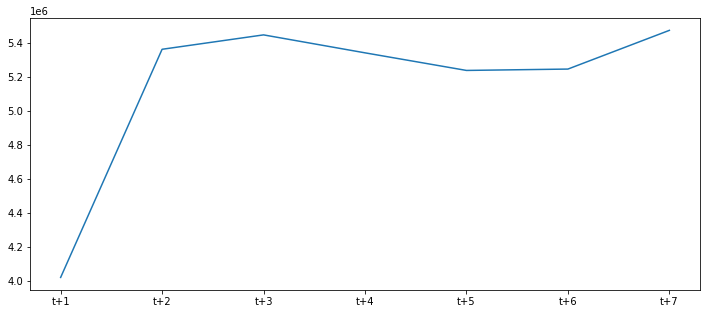

In [112]:
pd.Series(error_by_horizon_dir).plot(figsize=(12,5))

In [114]:
test_data = pd.DataFrame({'forecasts': forecasts, 'actual': y_test})
test_data.head()

,forecasts,actual
378,8.178560e+07,79789352.0
379,9.518500e+07,95094840.0
380,1.127513e+08,117452568.0
381,1.156112e+08,120959480.0
382,1.197671e+08,123346832.0


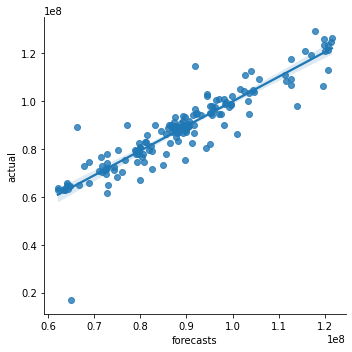

In [115]:
import seaborn as sns
sns.lmplot(x='forecasts', y='actual',data=test_data,fit_reg=True)

In [116]:
mean_absolute_error(y_test, forecasts)

3920732.5585185187

In [117]:
MASE(y_train, y_test, forecasts)

0.45787123194824453

In [118]:
large_y_test = y_test[y_test > 5]
large_forecasts = forecasts[y_test > 5]
mean_absolute_error(large_y_test, large_forecasts)

3920732.5585185187

In [120]:
from sklearn.metrics import  r2_score
r2_score(y_test, forecasts)

0.8341598091672502

In [121]:
r2_score(large_y_test, large_forecasts)

0.8341598091672502